In [1]:
#by Joh Schoeneberg 2020
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.external.tifffile

import os

import pandas as pd

In [2]:

import sys
import argparse

default_i = "./data/PositiveControl/FilamentProjections/TomoJune_Fil06_Projection_crop.tif"
default_refPlus = "./data/ReferenceImageStacks/PlusUp.tif"
default_refMinus = "./data/ReferenceImageStacks/MinusUp.tif"
default_o = "./output/"

# this is the default system argument value array. Uncomment to run independent of command line
sys.argv = ['actinPolarity.py','-i',default_i,'-refPlus',default_refPlus,'-refMinus',default_refMinus,'-o',default_o]


parser = argparse.ArgumentParser(description='ActinPolarity by Joh Schoeneberg 2020')

parser.add_argument('-i','--input', help='*.tif input filament', default=default_i, required=True)
parser.add_argument('-refPlus','--referencePlusUp', help='*.tif stack plusUp reference',default=default_refPlus, required=True)
parser.add_argument('-refMinus','--referenceMinusUp', help='*.tif stack minusUp reference',default=default_refMinus, required=True)
parser.add_argument('-o','--output', help='output folder path ./output/',default=default_o, required=True)
args = vars(parser.parse_args())



#parser.add_argument('-i', metavar='N', type=int, nargs='+',
#                   help='input filament.tif')
#parser.add_argument('--sum', dest='accumulate', action='store_const',
#                   const=sum, default=max,
#                   help='sum the integers (default: find the max)')


#args = vars(parser.parse_args())
#print(args)


{'input': './data/PositiveControl/FilamentProjections/TomoJune_Fil06_Projection_crop.tif', 'referencePlusUp': './data/ReferenceImageStacks/MinusUp.tif', 'referenceMinusUp': './data/ReferenceImageStacks/PlusUp.tif', 'output': './output/'}


In [3]:

#zoom call timestamp 19:00
width = 23;
height = 69;
every = 5;

#import mask
input_image_path = os.path.abspath(os.path.join(args['input']))


PlusUp_image_path = os.path.abspath(os.path.join(args['referencePlusUp']))
MinusUp_image_path = os.path.abspath(os.path.join(args['referenceMinusUp']))

output_folder_path = os.path.abspath(os.path.join(args['output']))
#create folder if it does not exist
from pathlib import Path
Path(output_folder_path).mkdir(parents=True, exist_ok=True)


image = skimage.external.tifffile.imread(input_image_path)
globalMin = np.min(image)
globalMax = np.max(image)

minusUpReference = skimage.external.tifffile.imread(MinusUp_image_path)
#print(image.shape)
#plt.imshow(minusUpReference[0],cmap='gray')
#plt.show()

plusUpReference = skimage.external.tifffile.imread(PlusUp_image_path)
#print(image.shape)
#plt.imshow(plusUpReference[0],cmap='gray')
#plt.show()

In [4]:

#import time
#start_time = time.time()

print("extracting subimages of shape (w,h) ({},{}) every {} pixel ...".format(width,height,every))

totalHeight = image.shape[0]
#print(totalHeight);
nSubpictures = (np.floor(((totalHeight-height)/every))).astype(int)
subpictures = []
for i in range(0,nSubpictures):
#    print(i)
    subpicture = image[i*every:height+i*every,:]

    skimage.external.tifffile.imsave(output_folder_path+"/output_"+str(i).zfill(5)+".tiff", subpicture, imagej=True );

#    plt.imshow(subpicture,cmap='gray')
#    plt.show()
    subpictures.append(subpicture)

print("found {} subpictures".format(len(subpictures)))
#print("--- %s seconds ---" % (time.time() - start_time))


found 45 subpictures


In [5]:
# plot the created pictures

#w=10
#h=90
#fig=plt.figure(figsize=(w, h))
#columns = 5
#rows = 9
#for i in range(1, columns*rows ):
#    img = np.random.randint(10, size=(h,w))
#    fig.add_subplot(rows, columns, i)
#    plt.imshow(subpictures[i],vmin=globalMin, vmax=globalMax,cmap='gray')
#plt.show()

In [6]:
# calculate correlation coefficient:
# from https://www.gcsca.net/IJ/Image_CorrelationJ_1o.java

def getR(d1, d2):
    d1 = np.array(d1).flatten()
    d2 = np.array(d2).flatten()
    t1 = 0
    t2 = 0
    sumValue = 0
    xMean = np.mean(d1)
    yMean = np.mean(d2)
    xStd = np.std(d1)
    yStd = np.std(d2)

    for i in range(0,len(d1)):
        t1 = (d1[i]-xMean)/xStd
        t2 = (d2[i]-yMean)/yStd
        sumValue = sumValue + (t1*t2)
    r = sumValue/(len(d1)-1)
    return(r)

In [7]:
#import time
#start_time = time.time()
print("calculating R values...")

rValuesPlusUpReference = []
rValuesMinusUpReference = []

for i in range(0,len(subpictures)):
    for j in range(0,len(plusUpReference)):
        rpu = getR(plusUpReference[j],subpictures[i])
        rValuesPlusUpReference.append(rpu)
    for k in range(0,len(minusUpReference)):
        rmu = getR(minusUpReference[k],subpictures[i])
        rValuesMinusUpReference.append(rmu)

#print("--- %s seconds ---" % (time.time() - start_time))


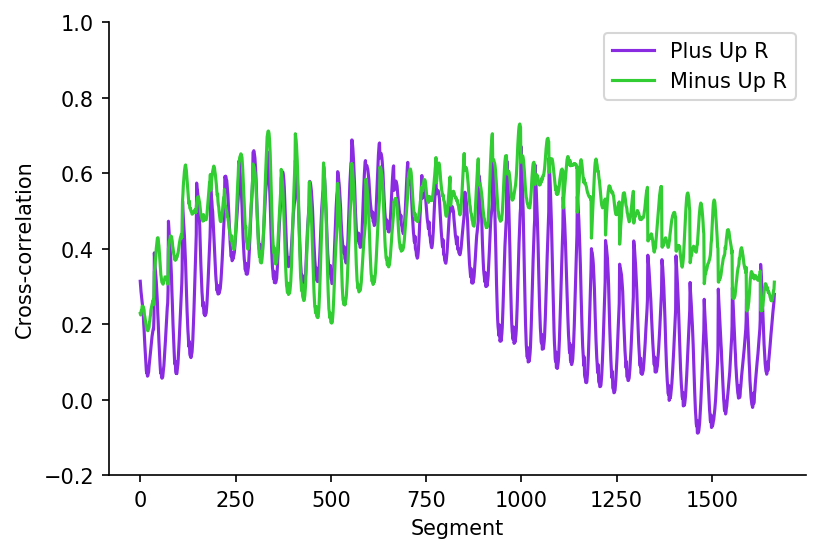

In [8]:
#https://matplotlib.org/3.1.0/gallery/color/named_colors.html

plt.figure(dpi=150)
plt.plot(rValuesPlusUpReference,c="blueviolet",label="Plus Up R")
plt.plot(rValuesMinusUpReference,c="limegreen",label="Minus Up R")
plt.xlabel("Segment")
plt.ylabel("Cross-correlation")
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc="upper right")
plt.ylim(-0.2,1)
plt.savefig(output_folder_path+'/plot.png')


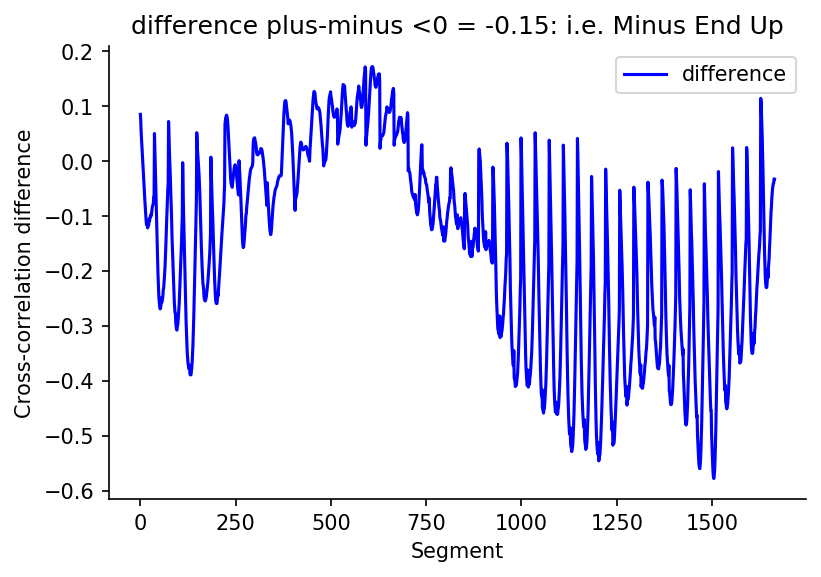

In [9]:
#https://matplotlib.org/3.1.0/gallery/color/named_colors.html

plt.figure(dpi=150)
plt.plot(np.array(rValuesPlusUpReference)-np.array(rValuesMinusUpReference),c="blue",label="difference")
plt.xlabel("Segment")
plt.ylabel("Cross-correlation difference")
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(loc="upper right")
#plt.ylim(-0.5,0.5)

avgDifference = np.round(np.mean(np.array(rValuesPlusUpReference)-np.array(rValuesMinusUpReference)),decimals=2)
if(np.mean(np.array(rValuesPlusUpReference)-np.array(rValuesMinusUpReference))<0):
    plt.title("difference plus-minus <0 = {}: i.e. Minus End Up".format(avgDifference))
    endUpDecision = "Minus End Up"
else:
    plt.title("difference plus-minus >=0 = {}: i.e. Plus End Up".format(avgDifference))
    endUpDecision = "Plus End Up"
    
plt.savefig(output_folder_path+'/plot_difference.png')



In [10]:
data = np.array([rValuesPlusUpReference, rValuesMinusUpReference])
#print( data.shape)
df = pd.DataFrame({'R_plusUpReference': data[0], 
                   'R_plusUpReference_area': np.sum(np.abs(data[0])), 
                   'R_minusUpReference': data[1], 
                   'R_minusUpReference_area': np.sum(np.abs(data[1])),
                   'R_Plus_minus_R-Minus:':avgDifference,
                   'R_Plus_minus_R-Minus:':endUpDecision})
print(df)
df.to_csv(output_folder_path+'/output.csv', index = True)

      R_plusUpReference  R_plusUpReference_area  R_minusUpReference  \
0              0.313417              534.235707            0.228086   
1              0.298648              534.235707            0.224184   
2              0.286317              534.235707            0.232779   
3              0.276911              534.235707            0.236451   
4              0.267036              534.235707            0.237072   
...                 ...                     ...                 ...   
1660           0.228768              534.235707            0.273370   
1661           0.239793              534.235707            0.280108   
1662           0.250077              534.235707            0.289932   
1663           0.258980              534.235707            0.291191   
1664           0.278642              534.235707            0.311120   

      R_minusUpReference_area R_Plus_minus_R-Minus:  
0                  785.762861          Minus End Up  
1                  785.762861          

In [ ]:
print("done.")
print("find the outputs in "+output_folder_path)